In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, losses, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2

In [3]:
DTYPE='float32'
K.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype=DTYPE)

In [4]:
# Define initial condition
def fun_u_0(x, xmin=0., xmax=1.):
    return tf.math.sin(2*pi*(x-xmin)/(xmax-xmin))

# Define residual of the PDE
def fun_r(t, u, u_x, u_xx, u_t, nu=3e-3):
    # params = nu
    res = u_t + u*u_x - nu*u_xx
    return res

In [5]:
# Set number of data points
N_0 = 100
N_b = 200
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0, xmin=lb[1], xmax=ub[1])

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
t_b = tf.tile(t_b, [1 ,2])
t_b = tf.reshape(t_b, (2*N_b, 1))
x_b = tf.concat([tf.ones((N_b, 1), dtype=DTYPE)*lb[1], tf.ones((N_b, 1), dtype=DTYPE)*ub[1]], axis=1)
x_b = tf.reshape(x_b, (2*N_b, 1))
X_b = tf.concat([t_b, x_b], axis=1)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

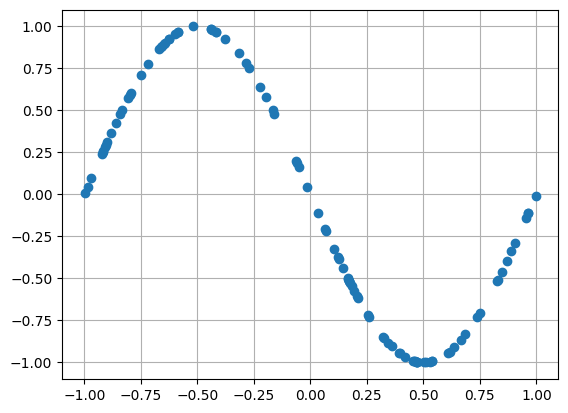

In [6]:
idx = np.argsort(x_0[:, 0])
plt.plot(np.array(x_0)[idx, 0], np.array(u_0)[idx, 0], 'o')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Initial Condition')
plt.show()

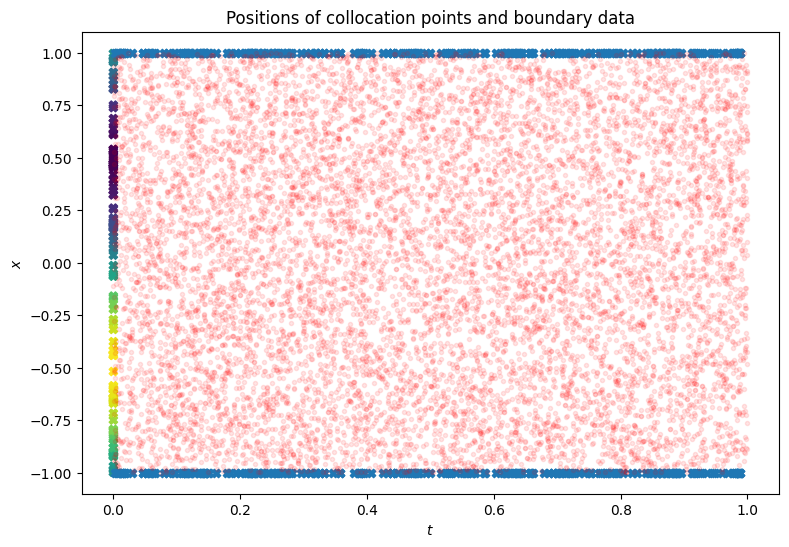

In [7]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
# plt.scatter(t_b, [lb[1]]*len(t_b), c='C0', marker='X', vmin=-1, vmax=1)
# plt.scatter(t_b, [ub[1]]*len(t_b), c='C0', marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c='C0', marker='X')
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary points');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [8]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initializes a feedforward NN taking in `[t, x]` and
    # outputting `u`
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(2))

    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    model.add(tf.keras.layers.Dense(1))

    return model

In [9]:
def get_r(model, X_r):
    # Computes the residual of the PDE at the provided
    # collocation points `X_r`
    t, x = X_r[..., 0:1], X_r[...,1:2]

    with tf.GradientTape(persistent=True) as tape_01:
        tape_01.watch(t)
        tape_01.watch(x)

        u = model(tf.stack([t[...,0], x[...,0]], axis=1))

        u_x = tape_01.gradient(u, x)

    u_t = tape_01.gradient(u, t)
    u_xx = tape_01.gradient(u_x, x)

    del tape_01

    return fun_r(t, u, u_x, u_xx, u_t)

In [10]:
def compute_grads(model, X):
    # Computes the gradient `u_x` for use in the
    # periodic boundary condition
    t, x = X[..., 0:1], X[...,1:2]

    with tf.GradientTape(persistent=True) as tape_01:
        tape_01.watch(t)
        tape_01.watch(x)

        u = model(tf.stack([t[...,0], x[...,0]], axis=1))

    u_x = tape_01.gradient(u, x)

    del tape_01

    return u, u_x

In [11]:
def compute_loss(model, X_r, X_0, u_0, X_b):
    # Computes the loss to be minimized

    # L_r - residual from collocation points
    r = get_r(model, X_r)
    L_r = tf.reduce_mean(tf.square(r))
    loss = L_r

    # L_i - loss from initial condition
    u_pred = model(X_0)
    loss += tf.reduce_mean(tf.square(u_0 - u_pred))

    # L_sb - loss from spatial boundary condition
    u, u_x = compute_grads(model, X_b)
    loss += tf.reduce_mean(tf.square(u[..., 0::2, :] - u[..., 1::2, :]))
    loss += tf.reduce_mean(tf.square(u_x[..., 0::2, :] - u_x[..., 1::2, :]))

    return loss

In [12]:
def get_grad(model, X_r, X_0, u_0, X_b):
    # Computes gradient of loss w.r.t. model params

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_0, u_0, X_b)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [13]:
# create and intialize the NN model, and other training params
model = init_model(num_hidden_layers=8, num_neurons_per_layer=20)

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 3000],[1e-2, 1e-3, 5e-4])

optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [14]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_0, u_0, X_b)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = 7500
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 5.89595377e-01
It 00050: loss = 3.83010596e-01
It 00100: loss = 2.08801150e-01
It 00150: loss = 1.59109771e-01
It 00200: loss = 1.45419791e-01
It 00250: loss = 1.31128266e-01
It 00300: loss = 1.04820088e-01
It 00350: loss = 9.67689604e-02
It 00400: loss = 1.01443708e-01
It 00450: loss = 1.05974711e-01
It 00500: loss = 8.55934620e-02
It 00550: loss = 9.54996943e-02
It 00600: loss = 7.72705302e-02
It 00650: loss = 6.43177107e-02
It 00700: loss = 5.72741516e-02
It 00750: loss = 4.35141809e-02
It 00800: loss = 1.09796681e-01
It 00850: loss = 6.15888387e-02
It 00900: loss = 4.25606370e-02
It 00950: loss = 2.21427120e-02
It 01000: loss = 3.90291989e-01
It 01050: loss = 9.91751328e-02
It 01100: loss = 9.01524127e-02
It 01150: loss = 8.64266306e-02
It 01200: loss = 8.39234143e-02
It 01250: loss = 8.18748400e-02
It 01300: loss = 7.98581988e-02
It 01350: loss = 7.76539221e-02
It 01400: loss = 7.55059347e-02
It 01450: loss = 7.32425302e-02
It 01500: loss = 7.07598999e-02
It 01550

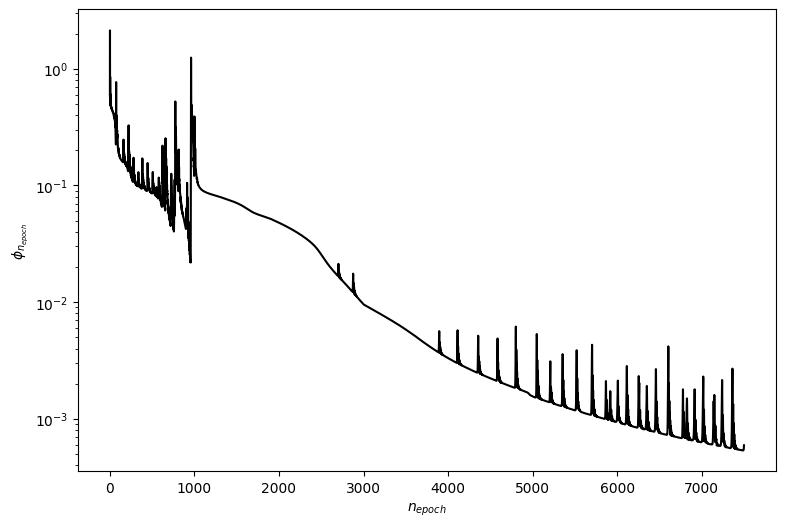

In [15]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

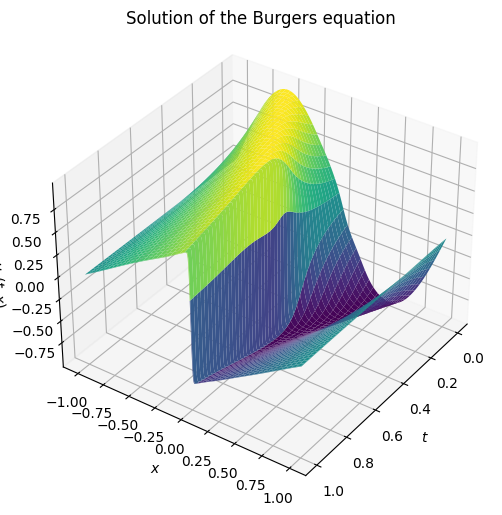

In [16]:
from mpl_toolkits.mplot3d import Axes3D
# plt.ion()
# Set up meshgrid
N = 600
alpha = 0.
tspace = np.linspace(lb[0] + alpha*(ub[0]-lb[0]), ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of the Burgers equation');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

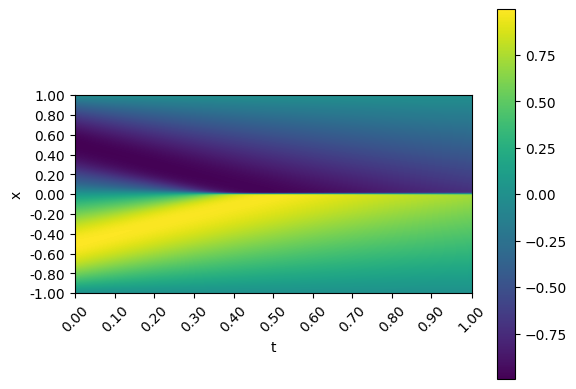

In [17]:
plt.imshow(U, origin='lower', aspect=0.5)

plt.xlabel('t')
plt.ylabel('x')

plt.yticks(np.linspace(0, N+1, 11, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(lb[1], ub[1], 11)])
plt.xticks(np.linspace(0, N+1, 11, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(lb[0] + alpha*(ub[0]-lb[0]), ub[0], 11)], rotation=45)

plt.colorbar()
plt.show()

Finite Difference Solution

In [18]:
def RK4_integrator(fX, X0, delta_t, **kwargs):
    '''
    fX = callable function
    X0 = initial condition
    delta_t = time interval

    This integrator is specific for an 'fX' that
    doesn't require 't' in its argument.
    '''

    k1 = fX(X0, **kwargs)
    k2 = fX(X0 + 0.5 * k1 * delta_t, **kwargs)
    k3 = fX(X0 + 0.5 * k2 * delta_t, **kwargs)
    k4 = fX(X0 + k3 * delta_t, **kwargs)
    X_next = X0 + delta_t * (k1 + 2*k2 + 2*k3 + k4) / 6
    return X_next

In [19]:
nu = 3e-3

dt = 0.001
N_x = 601

N_t = int( (tmax-tmin+0.5*dt)//dt ) + 1

def fun_u_0(x, xmin=0., xmax=1.):
    return np.sin(2*pi*(x-xmin)/(xmax-xmin))

In [20]:
x_arr = np.linspace(xmin, xmax, N_x)
dx = np.mean(x_arr[1:] - x_arr[0:-1])

In [21]:
u_arr = np.empty(shape=(N_t, N_x))
u_arr[0] = fun_u_0(x_arr, xmin=xmin, xmax=xmax)

In [22]:
def u_prime(u, dt=dt, dx=dx, nu=nu):
    u_sq = u*u
    idx_p1 = (np.arange(0, len(u)) + 1)%len(u)
    idx_m1 = (np.arange(0, len(u)) - 1)%len(u)
    u_sq_x = 0.5*(u_sq[idx_p1] - u_sq[idx_m1])/dx

    u_xx = (u[idx_p1] - 2*u + u[idx_m1])/(dx*dx)

    res = -0.5*u_sq_x + nu*u_xx
    return res

In [23]:
kwargs = {'dt':dt, 'dx':dx, 'nu':nu}
for i in range(1, N_t):
    u0 = u_arr[i-1]
    u_new = RK4_integrator(u_prime, u0, dt, **kwargs)
    u_arr[i, :] = u_new[:]

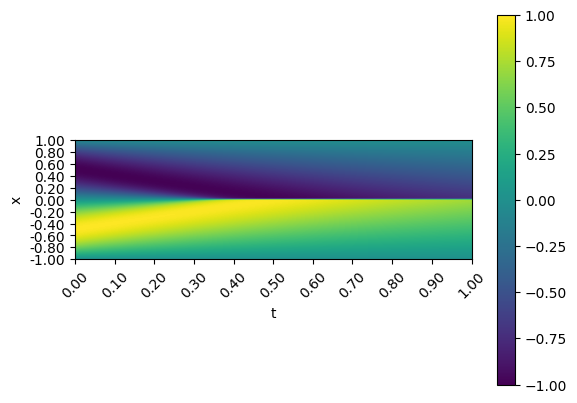

In [25]:
alpha = 0.
plt.imshow(u_arr.transpose(), origin='lower', aspect=0.5)

plt.xlabel('t')
plt.ylabel('x')

plt.yticks(np.linspace(0, N_x, 11, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(xmin, xmax, 11)])
plt.xticks(np.linspace(0, N_t, 11, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(tmin + alpha*(tmax-tmin), tmax, 11)], rotation=45)

plt.colorbar()
plt.show()

In [31]:
tspace = np.arange(N_t)*dt
xspace = x_arr
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N_x, N_t)

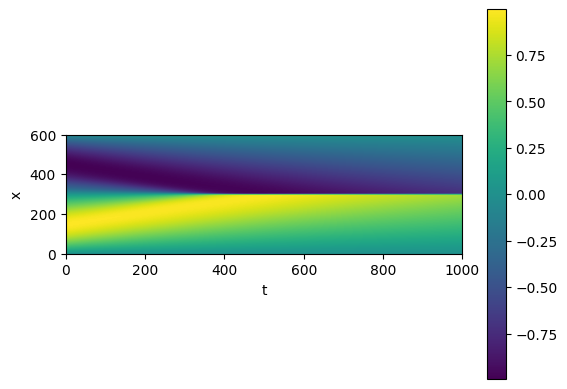

In [32]:
plt.imshow(U, origin='lower', aspect=0.5)

plt.xlabel('t')
plt.ylabel('x')

# plt.yticks(np.linspace(0, N+1, 11, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(lb[1], ub[1], 11)])
# plt.xticks(np.linspace(0, N+1, 11, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(lb[0] + alpha*(ub[0]-lb[0]), ub[0], 11)], rotation=45)

plt.colorbar()
plt.show()

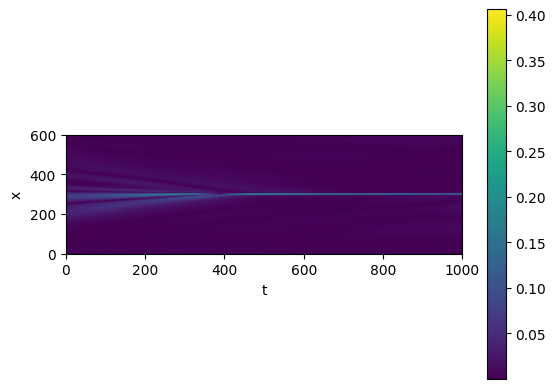

In [48]:
# error = np.clip(1 - U/u_arr.transpose(), -1e-2, 1e-2)
error = np.abs(u_arr.transpose() - U) / np.std(u_arr.transpose(), axis=0)

plt.imshow(error, origin='lower', aspect=0.5)

plt.xlabel('t')
plt.ylabel('x')

# plt.yticks(np.linspace(0, N+1, 11, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(lb[1], ub[1], 11)])
# plt.xticks(np.linspace(0, N+1, 11, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(lb[0] + alpha*(ub[0]-lb[0]), ub[0], 11)], rotation=45)

plt.colorbar()
plt.show()

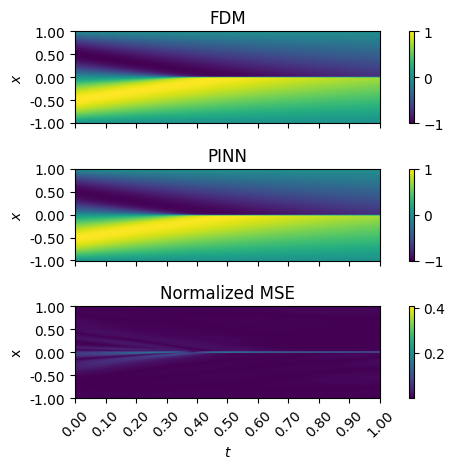

In [89]:
n_yticks = 5
fig, ax = plt.subplots(3, sharex=True)

vmin = min(np.min(u_arr), np.min(U))
vmax = max(np.max(u_arr), np.max(U))


im_fdm = ax[0].imshow(u_arr.transpose(), origin='lower', aspect=0.5, vmin=vmin, vmax=vmax)
ax[0].set_ylabel(r'$x$')
ax[0].set_yticks(np.linspace(0, N_x, n_yticks, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(xmin, xmax, n_yticks)])
ax[0].set_title('FDM')
plt.colorbar(im_fdm)

im_pinn = ax[1].imshow(U, origin='lower', aspect=0.5, vmin=vmin, vmax=vmax)
ax[1].set_ylabel(r'$x$')
ax[1].set_yticks(np.linspace(0, N_x, n_yticks, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(xmin, xmax, n_yticks)])
ax[1].set_title('PINN')
plt.colorbar(im_pinn)

error = np.abs(u_arr.transpose() - U) / np.std(u_arr.transpose(), axis=0)

im_e = ax[2].imshow(error, origin='lower', aspect=0.5)
ax[2].set_ylabel('x')
ax[2].set_yticks(np.linspace(0, N_x, n_yticks, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(xmin, xmax, n_yticks)])
ax[2].set_title('Normalized MSE')

ax[2].set_xlabel(r'$t$')
ax[2].set_xticks(np.linspace(0, N_t, 11, dtype='int'), ['{:.2f}'.format(l) for l in np.linspace(lb[0] + alpha*(ub[0]-lb[0]), ub[0], 11)], rotation=45)
plt.colorbar(im_e)

plt.tight_layout()

plt.savefig('burgers.png', dpi=600, bbox_inches='tight')